In [3]:
import numpy as np
import pandas as pd

from collections import defaultdict, Counter

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

In [4]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
stops_tidy = pd.read_csv('../data/corpus.csv',index_col=0)
df = stops_tidy[~stops_tidy.Translator.str.contains('Myst')]
df

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...,0.0,0.097100,0.534050,0.0,0.0,0.0,0.145650,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...,0.0,0.200297,0.578636,0.0,0.0,0.0,0.155787,...,0.000000,0.000000,0.022255,0.0,0.222552,0.311573,0.022255,0.0,0.066766,0.0
2,Bur,Com,horis anni invenire quartam coniugationem comp...,0.0,0.230022,0.575055,0.0,0.0,0.0,0.000000,...,0.046004,0.000000,0.000000,0.0,0.253024,0.138013,0.046004,0.0,0.230022,0.0
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...,0.0,0.243044,0.710436,0.0,0.0,0.0,0.037391,...,0.000000,0.000000,0.000000,0.0,0.280435,0.168261,0.000000,0.0,0.037391,0.0
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...,0.0,0.649435,0.409426,0.0,0.0,0.0,0.070591,...,0.000000,0.000000,0.000000,0.0,0.395308,0.211772,0.000000,0.0,0.070591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,Bur,Fid,ostendat quod secundum veritatem est homo cum ...,0.0,0.024500,0.538996,0.0,0.0,0.0,0.171499,...,0.000000,0.000000,0.000000,0.0,0.587995,0.024500,0.000000,0.0,0.024500,0.0
1181,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...,0.0,0.000000,0.421459,0.0,0.0,0.0,0.049583,...,0.000000,0.000000,0.000000,0.0,0.223125,0.049583,0.024792,0.0,0.074375,0.0
1182,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...,0.0,0.000000,0.738485,0.0,0.0,0.0,0.096324,...,0.000000,0.032108,0.000000,0.0,0.481621,0.064216,0.032108,0.0,0.032108,0.0
1183,Bur,Fid,uxorem suam et concepit et genuit quare propte...,0.0,0.000000,0.666795,0.0,0.0,0.0,0.156893,...,0.000000,0.078446,0.000000,0.0,0.274563,0.039223,0.000000,0.0,0.039223,0.0


In [6]:
samp_ctr = Counter(df.Translator)
samp_ctr

Counter({'Wil': 554,
         'Bur': 371,
         'Jam': 87,
         'Anon': 66,
         'Bar': 44,
         'Arist': 35})

In [7]:
SAMPLE_SIZE = min(samp_ctr.values())//2
FUNCWORDS = df.columns[3:]

In [8]:
# Not currently used, because the class imbalance skews this towards the
# features that are best for telling the most common classes apart.


def mi_from_df(df: pd.DataFrame) -> pd.DataFrame:
    # The way this works is that we create an indicator variable of the same
    # length as the df, where rows with the given translator are set to True and
    # all the others are False. We then calculate the mutual information of the
    # whole df against this indicator. In other words we ask 'which features are
    # the most informative for deciding whether the dependent indicator variable
    # will be True or False' which is the same as saying 'which features help us
    # tell if this is the translator'. We need to do this individually for each
    # change in the discrete dependent variable (the translator).
    ret = []
    for transl in df.Translator.unique():
        # boolean vector
        ovr_y = df.Translator.apply(lambda x: x == transl)
        # MI of each feature (column) against this translator
        mi = mutual_info_classif(
            df.drop(["Translator", "Work", "Chunk"], axis=1), ovr_y, random_state=42
        )
        # list of tuples (MI_score, feature), sorted by score
        ranked = sorted(list(zip(mi, df.columns[3:])), key=lambda x: x[0], reverse=True)
        for x in ranked:
            w = x[1]  # feature (stopword)
            # simple odds - how much more or less likely is this translator to
            # use this stopword vs the average
            odds = df[df.Translator == transl][w].mean() / df[w].mean()
            ret.append({"translator": transl, "word": x[1], "mi": x[0], "odds": odds})
    return pd.DataFrame(ret)

In [9]:
def bootstrap_mi(
    df: pd.DataFrame, n: int = 100, rng: np.random.RandomState = np.random.RandomState()
) -> pd.DataFrame:
    # for each bootstrap balanced sample, calculate an MI vector as before
    raw_arrays = defaultdict(list)
    for _ in range(n):
        samp = (
            df.groupby("Translator")
            .apply(lambda x: x.sample(SAMPLE_SIZE, random_state=rng))
            .reset_index(drop=True)
        )
        for transl in samp.Translator.unique():
            ovr_y = samp.Translator.apply(lambda x: x == transl)
            mi = mutual_info_classif(
                samp.drop(["Translator", "Work", "Chunk"], axis=1),
                ovr_y,
                random_state=rng,
            )
            raw_arrays[transl].append(mi)

    # Now use the average bootstrapped MI, but calculate relative odds vs the
    # entire corpus (it's just a guide to whether the word more or less common)
    ret = []
    for transl in df.Translator.unique():
        mi = np.array(raw_arrays[transl]).mean(axis=0)
        ranked = sorted(list(zip(mi, FUNCWORDS)), key=lambda x: x[0], reverse=True)
        for x in ranked:
            w = x[1]
            odds = df[df.Translator == transl][w].mean() / df[w].mean()
            ret.append({"translator": transl, "word": x[1], "mi": x[0], "odds": odds})

    return pd.DataFrame(ret)

In [29]:
def bootstrap_mean(
    df: pd.DataFrame, n: int = 100, rng: np.random.RandomState = np.random.RandomState()
) -> np.ndarray:
    # for each bootstrap balanced sample, calculate an MI vector as before
    ret = []
    for _ in range(n):
        samp = (
            df.groupby("Translator")
            .apply(lambda x: x.sample(SAMPLE_SIZE, random_state=rng))
            .reset_index(drop=True)
        )
        ret.append(samp[FUNCWORDS].agg("mean"))
    return np.mean(ret, axis=0)

In [30]:
bm = pd.DataFrame(zip(FUNCWORDS,bootstrap_mean(df,rng=np.random.RandomState(42))),columns=['word','grand_mean'])

In [12]:
bmi = bootstrap_mi(df, rng=np.random.RandomState(42))
bmi

,translator,word,mi,odds
0,Bur,rursus,0.191236,3.020470
1,Bur,sic,0.142349,0.160799
2,Bur,denique,0.132132,3.103961
3,Bur,iterum,0.106269,0.039260
4,Bur,namque,0.097185,0.008990
...,...,...,...,...
319,Jam,dehinc,0.017399,0.000000
320,Jam,praecipue,0.017166,0.000000
321,Jam,uidelicet,0.016937,0.349423
322,Jam,multotiens,0.015099,0.904805


In [13]:
# Merge in just Bar and Wil's MI scores per function word. Merges on 'word'
# because that's the only shared column.
merged = bm.merge(bmi[bmi.translator == "Bar"][["word", "mi"]]).rename(
    columns={"mi": "mi_bar"}
)
merged = merged.merge(bmi[bmi.translator == "Wil"][["word", "mi"]]).rename(
    columns={"mi": "mi_wil"}
)
merged

,word,grand_mean,mi_bar,mi_wil
0,atqui,0.006405,0.022852,0.025410
1,aut,0.165118,0.033289,0.046792
2,autem,0.504568,0.152396,0.073535
3,certe,0.011924,0.018723,0.029941
4,ceu,0.005814,0.020926,0.021639
5,confestim,0.004155,0.046143,0.013684
6,cum,0.088341,0.068377,0.036543
7,dehinc,0.001281,0.014310,0.016916
8,deinceps,0.005953,0.031897,0.019897
9,demum,0.005769,0.017644,0.017939


This gives us the 'most important' function words for determining each translator, essentially based on one-versus-rest mutual information. The odds ratio just tells us whether it's important because the translator uses the word more (or less) than average. The odds scores are easily distorted by rare words though.

In [14]:
bs_results = bootstrap_mi(df,100,rng=np.random.RandomState(42))
bs_results.groupby('translator').head(5).reset_index(drop=True)

,translator,word,mi,odds
0,Bur,rursus,0.191236,3.020470
1,Bur,sic,0.142349,0.160799
2,Bur,denique,0.132132,3.103961
3,Bur,iterum,0.106269,0.039260
4,Bur,namque,0.097185,0.008990
5,Arist,sane,0.390025,31.628468
6,Arist,quoque,0.377797,27.497715
7,Arist,nempe,0.356799,27.452630
8,Arist,quippe,0.333547,24.125875
9,Arist,eciam,0.300780,9.132882


In [15]:
merged['mi_wilbar'] = merged['mi_wil'] + merged['mi_bar']

In [16]:
bm = pd.DataFrame(
    df[df.Translator == "Bar"].drop(["Translator", "Work", "Chunk"], axis=1).agg("mean")
).reset_index()
bm.columns = ["word", "bar_mean"]

In [17]:
wm = pd.DataFrame(
    df[df.Translator == "Wil"].drop(["Translator", "Work", "Chunk"], axis=1).agg("mean")
).reset_index()
wm.columns = ["word", "wil_mean"]

In [18]:
m3 = pd.DataFrame(
    stops_tidy[stops_tidy.Work == "3"]
    .drop(["Translator", "Work", "Chunk"], axis=1)
    .agg("mean")
).reset_index()
m3.columns = ["word", "myst3_mean"]

In [19]:
raw_res = (
    merged.merge(bm, on="word")
    .merge(wm, on="word")
    .merge(m3, on="word")
    .sort_values(by="mi_wilbar", ascending=False)
)
raw_res

,word,grand_mean,mi_bar,mi_wil,mi_wilbar,bar_mean,wil_mean,myst3_mean
52,uero,0.177830,0.062589,0.208382,0.270972,0.078589,0.012468,0.080478
2,autem,0.504568,0.152396,0.073535,0.225931,0.748680,0.642108,0.593294
36,quoniam,0.114963,0.071498,0.094622,0.166121,0.041184,0.031342,0.007326
26,namque,0.025930,0.062377,0.102509,0.164886,0.002817,0.000114,0.001551
20,ita,0.058460,0.045317,0.093271,0.138588,0.067471,0.010870,0.048406
48,ut,0.176628,0.109645,0.018689,0.128334,0.076720,0.154780,0.083307
29,puta,0.011806,0.069288,0.053508,0.122796,0.042332,0.018040,0.000000
25,nam,0.037322,0.088225,0.029810,0.118036,0.000619,0.022939,0.009935
14,exinde,0.002199,0.093181,0.017466,0.110647,0.011925,0.000000,0.002825
30,quando,0.039315,0.089543,0.019720,0.109263,0.103029,0.024557,0.045187


In [20]:
# transpose, and scale by 'columns', in other words z-scale the four means we have
# per word so they can be read on a single figure. TODO use a MinMaxScaler instead?
raw_res[['bar_mean','grand_mean', 'wil_mean','myst3_mean']].T

,52,2,36,26,20,48,29,25,14,30,...,10,39,23,24,38,51,9,53,7,16
bar_mean,0.078589,0.748680,0.041184,0.002817,0.067471,0.076720,0.042332,0.000619,0.011925,0.103029,...,0.000878,0.000591,0.001013,0.006054,0.000000,0.000000,0.000000,0.000618,0.000000,0.000000
grand_mean,0.177830,0.504568,0.114963,0.025930,0.058460,0.176628,0.011806,0.037322,0.002199,0.039315,...,0.003877,0.003866,0.002102,0.005058,0.002693,0.003065,0.005769,0.001761,0.001281,0.001575
wil_mean,0.012468,0.642108,0.031342,0.000114,0.010870,0.154780,0.018040,0.022939,0.000000,0.024557,...,0.000000,0.008433,0.002536,0.001911,0.000095,0.001784,0.000000,0.004637,0.000035,0.000499
myst3_mean,0.080478,0.593294,0.007326,0.001551,0.048406,0.083307,0.000000,0.009935,0.002825,0.045187,...,0.000000,0.043853,0.005426,0.000000,0.000000,0.019655,0.000000,0.000000,0.000000,0.000000


In [21]:
# we're only using these four points for the rescaling, so don't center them
# around mean, we will center them manually later. Note that the z-score is
# basically nonsense. To get a meaningful z we'd need to do some much more
# elaborate process, but I don't want to give them impression that we're
# proposing any kind of confidence or hypothesis.

X = raw_res[['bar_mean','grand_mean', 'wil_mean','myst3_mean']].T
tst = pd.DataFrame(StandardScaler(with_mean=False).fit_transform(X).T, columns=['bar_scaled', 'grand_scaled', 'wil_scaled','myst3_scaled'])
tst.index = raw_res.index

In [22]:
combined = pd.concat([raw_res,tst],axis=1).head(10)
combined

,word,grand_mean,mi_bar,mi_wil,mi_wilbar,bar_mean,wil_mean,myst3_mean,bar_scaled,grand_scaled,wil_scaled,myst3_scaled
52,uero,0.177830,0.062589,0.208382,0.270972,0.078589,0.012468,0.080478,1.332306,3.014727,0.211370,1.364332
2,autem,0.504568,0.152396,0.073535,0.225931,0.748680,0.642108,0.593294,8.495350,5.725386,7.286061,6.732171
36,quoniam,0.114963,0.071498,0.094622,0.166121,0.041184,0.031342,0.007326,1.024787,2.860606,0.779869,0.182286
26,namque,0.025930,0.062377,0.102509,0.164886,0.002817,0.000114,0.001551,0.265129,2.440657,0.010774,0.145972
20,ita,0.058460,0.045317,0.093271,0.138588,0.067471,0.010870,0.048406,3.132415,2.714069,0.504635,2.247282
48,ut,0.176628,0.109645,0.018689,0.128334,0.076720,0.154780,0.083307,1.759710,4.051281,3.550146,1.910805
29,puta,0.011806,0.069288,0.053508,0.122796,0.042332,0.018040,0.000000,2.740520,0.764320,1.167924,0.000000
25,nam,0.037322,0.088225,0.029810,0.118036,0.000619,0.022939,0.009935,0.044741,2.699565,1.659214,0.718603
14,exinde,0.002199,0.093181,0.017466,0.110647,0.011925,0.000000,0.002825,2.614676,0.482203,0.000000,0.619439
30,quando,0.039315,0.089543,0.019720,0.109263,0.103029,0.024557,0.045187,3.453413,1.317780,0.823109,1.514610


In [23]:
def closer(r):
    if abs(r["myst3_scaled"] - r["wil_scaled"]) >= abs(
        r["myst3_scaled"] - r["bar_scaled"]
    ):
        return "B"
    else:
        return "W"

In [24]:
combined['closer'] = combined.apply(closer, axis=1)
combined

,word,grand_mean,mi_bar,mi_wil,mi_wilbar,bar_mean,wil_mean,myst3_mean,bar_scaled,grand_scaled,wil_scaled,myst3_scaled,closer
52,uero,0.177830,0.062589,0.208382,0.270972,0.078589,0.012468,0.080478,1.332306,3.014727,0.211370,1.364332,B
2,autem,0.504568,0.152396,0.073535,0.225931,0.748680,0.642108,0.593294,8.495350,5.725386,7.286061,6.732171,W
36,quoniam,0.114963,0.071498,0.094622,0.166121,0.041184,0.031342,0.007326,1.024787,2.860606,0.779869,0.182286,W
26,namque,0.025930,0.062377,0.102509,0.164886,0.002817,0.000114,0.001551,0.265129,2.440657,0.010774,0.145972,B
20,ita,0.058460,0.045317,0.093271,0.138588,0.067471,0.010870,0.048406,3.132415,2.714069,0.504635,2.247282,B
48,ut,0.176628,0.109645,0.018689,0.128334,0.076720,0.154780,0.083307,1.759710,4.051281,3.550146,1.910805,B
29,puta,0.011806,0.069288,0.053508,0.122796,0.042332,0.018040,0.000000,2.740520,0.764320,1.167924,0.000000,W
25,nam,0.037322,0.088225,0.029810,0.118036,0.000619,0.022939,0.009935,0.044741,2.699565,1.659214,0.718603,B
14,exinde,0.002199,0.093181,0.017466,0.110647,0.011925,0.000000,0.002825,2.614676,0.482203,0.000000,0.619439,W
30,quando,0.039315,0.089543,0.019720,0.109263,0.103029,0.024557,0.045187,3.453413,1.317780,0.823109,1.514610,W


In [25]:
# Manually center around the bootstrap mean

combined['bar_scaled'] = combined['bar_scaled'] - combined['grand_scaled']
combined['wil_scaled'] = combined['wil_scaled'] - combined['grand_scaled']
combined['myst3_scaled'] = combined['myst3_scaled'] - combined['grand_scaled']
combined['grand_scaled'] = combined['grand_scaled'] - combined['grand_scaled']

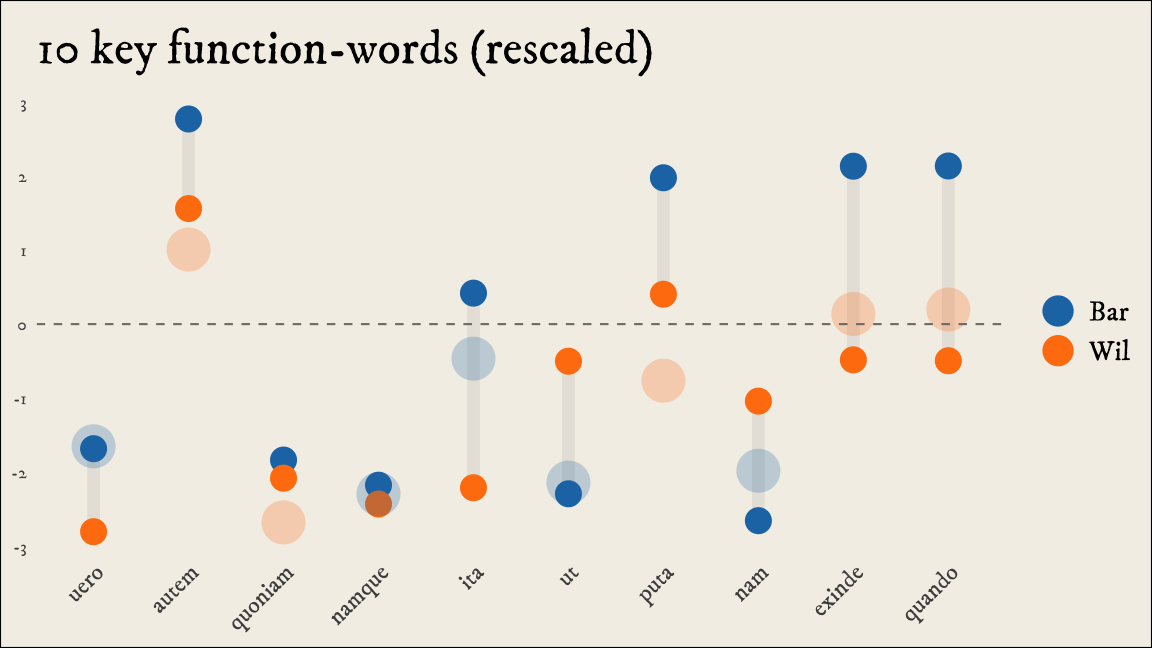

In [35]:
%%R -i combined -h 4.5 -w 8 -u in -r 144

library(ggplot2)
library(paletteer)
library(showtext)
library(ggforce)
library(forcats)
font_add_google("IM Fell DW Pica", "fnt")
showtext_auto()

bgcol = '#f4f0e8'
fgcol = 'black'

ggplot(data=combined, aes(x=fct_inorder(word))) +
geom_segment(aes(x=word,xend=word, y=bar_scaled,yend=wil_scaled),colour='#c4c0b8',size=3,alpha=0.25) +
geom_point(size=6, shape=16, aes(y=bar_scaled),color='#1f77b4ff') +
geom_point(size=6, shape=16, aes(y=wil_scaled),color='#ff7f0eff') +
geom_point(size=10, alpha=0.25, shape=16, aes(y=myst3_scaled,color=closer)) +
geom_hline(yintercept=0,linetype='dashed',color='grey50') +
scale_x_discrete(limits=combined$word) +
theme_minimal() +
scale_colour_paletteer_d("ggsci::category20_d3",labels=c('Bar','Wil')) +
ggtitle("10 key function-words (rescaled)") +
guides(color = guide_legend(ncol=1,override.aes =list(size=7, alpha=1))) +
    theme(
        panel.border = element_blank(),
        panel.background = element_rect(fill = bgcol,color=bgcol),
        plot.background = element_rect(fill = bgcol),
        plot.title=element_text(margin=margin(10,0,10,0),size=24),
        legend.title=element_blank(),
        #legend.position='none',
        legend.text=element_text(size=14),
        legend.key.size = unit(0, 'lines'),
        axis.title.x=element_blank(),
        axis.text.x=element_text(angle=45,size=12,hjust=1),
        # axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        # axis.text.y=element_blank(),
        # axis.ticks.y=element_blank(),
        text=element_text(family="fnt",color=fgcol),
        panel.grid.minor=element_blank(),
        panel.grid.major=element_blank()
    )

# fn <- "../figures/10fw_wilbar.pdf"
# ggsave(fn, dpi=300, width=8, height=4.5)